In [ ]:
# Let's start by retrieving some Magic card images using the Scryfall API
# https://scryfall.com/docs/api
# We'll be using the Scryfall python library
# https://github.com/NandaScott/Scrython

In [1]:
import requests
from requests.exceptions import TooManyRedirects, ReadTimeout, ConnectionError
import json
import pprint
import time
import shutil
import os
import os.path
import glob
import csv
from PIL import Image
import random
import numpy as np
import errno
import mxnet as mx
import csv
import matplotlib.pyplot as plt

URL='https://api.scryfall.com'
#OUTDIR='/Users/agussman/Documents/DeepLens/deeplens-magiccards/data'
OUTDIR='/Users/aarongussman/Documents/Personal/deeplens-magiccards/data'
FOREGROUNDS_DIR = os.path.join(OUTDIR, "foregrounds")
BACKGROUNDS_DIR = os.path.join(OUTDIR, "backgrounds")

## Training

In [2]:
batch_size = 32 # Number of examples per batch, some examples are 4, pikachu uses 32
data_shape = 256 # Data shape in (channels, height, width) format. For now, only RGB image with 3 channels is supported.
                 # some example had 224, but pikachu example uses 256
data_iter = mx.image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
                                      path_imglist=OUTDIR+'/train.lst', path_root='/')
class_names = ['magic_card']
num_class = len(class_names)
train_data = data_iter
epochs = 4

test_dir = os.path.join(OUTDIR, 'test')

In [ ]:
batch.label

[0.         0.088      0.074      0.808      0.722      0.592
 0.088      0.722      0.5706667  0.204      0.808      0.074
 0.32533333]


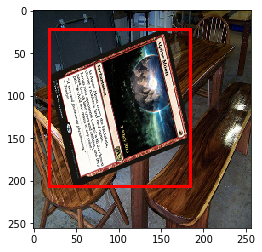

In [4]:
# https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html
data_iter.reset()
batch = data_iter.next()
#print(batch)
#data_shape = 256

i = 0

img = batch.data[0][i].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
#img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)

# Create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(img)

# draw bounding boxes on image
for label in batch.label[0][i].asnumpy():
    if label[0] < 0:
        print("MISSING LABEL????")
        break
    print(label)
    ymin, xmin, ymax, xmax = [int(x * data_shape) for x in label[1:5]]
    #xmin = xmin / width
    #xmax = xmax / width
    #ymin = ymin / height
    #ymax = ymax / height
    #xmin, ymin, xmax, ymax = label[1:5]
    # scale to new size
    #xmin, ymin, xmax, ymax = 58, 179, 150, 279
    #xmin, ymin, xmax, ymax = label[, 179, 150, 279
    
    # TODO: Pickup with this (need to scale height/width)
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    ax.add_patch(rect)

plt.show()

In [ ]:
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
#for i in range(4):
#    plt.subplot(1,4,i+1)
#    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.imshow(data[1].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

In [ ]:
# Working forward from https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html

In [5]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>


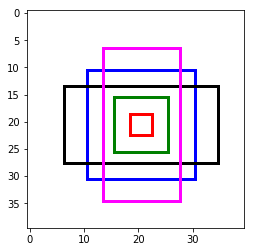

In [6]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [7]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 55, 20, 20)


In [8]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


In [9]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


In [10]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [11]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [12]:
# TODO This needs to be made something actual?
# from the text: Common choices follow the architectures of the state-of-the-art convolution neural 
# networks for image classification. For demonstration purpose, we just stack several down sampling 
# blocks to form the body network.
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


In [13]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    #downsamples = nn.Sequential()
    #class_preds = nn.Sequential()
    #box_preds = nn.Sequential()
    
    downsamples = nn.HybridSequential()
    class_preds = nn.HybridSequential()
    box_preds = nn.HybridSequential()


    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (5): Activati

In [14]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [15]:
from mxnet import gluon
#class ToySSD(gluon.Block):
class ToySSD(gluon.HybridBlock):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [ ]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)


In [17]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [18]:
from mxnet import gluon
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)


FocalLoss(batch_axis=0, w=None)


In [19]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [20]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

In [21]:
from mxnet import nd
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

# This reports no GPU...
# Looks like I'd need to follow instructions here to get it to work:
# https://mxnet.incubator.apache.org/install/index.html

No GPU enabled, fall back to CPU, sit back and be patient...


In [22]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [23]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [24]:
# DID YOU SET train_data above?
#epochs = 150  # set larger to get better performance
#epochs = 50
log_interval = 20
from_scratch = True  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 148
    pretrained = 'ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not osp.exists(pretrained) or not verified(pretrained, sha1):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_params(pretrained, ctx)

In [25]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

print('{} training images, {} epochs (%f)'.format(n_generated_images, epochs, time.time()-tic))    
# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

[Epoch 0 Batch 19] speed: 12.498136 samples/s, training: accuracy=0.930729, mae=0.006197
[Epoch 0 Batch 39] speed: 12.597518 samples/s, training: accuracy=0.958641, mae=0.005965
[Epoch 0] training: accuracy=0.960504, mae=0.005872
[Epoch 0] time cost: 347.278796
[Epoch 1 Batch 19] speed: 13.211465 samples/s, training: accuracy=0.990036, mae=0.005577
[Epoch 1 Batch 39] speed: 12.880571 samples/s, training: accuracy=0.990645, mae=0.005420
[Epoch 1] training: accuracy=0.988144, mae=0.005348
[Epoch 1] time cost: 350.518110
[Epoch 2 Batch 19] speed: 12.829165 samples/s, training: accuracy=0.991902, mae=0.005204
[Epoch 2 Batch 39] speed: 13.002014 samples/s, training: accuracy=0.992143, mae=0.005085
[Epoch 2] training: accuracy=0.989545, mae=0.005025
[Epoch 2] time cost: 350.577574
[Epoch 3 Batch 19] speed: 12.488414 samples/s, training: accuracy=0.992587, mae=0.004955
[Epoch 3 Batch 39] speed: 12.644754 samples/s, training: accuracy=0.992743, mae=0.004861
[Epoch 3] training: accuracy=0.99012

NameError: name 'n_generated_images' is not defined

In [28]:
# Test
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image
i = 0
image = cv2.imread(os.path.join(test_dir, 'image_{0:04d}.png'.format(i)))
x = preprocess(image)
print('x', x.shape)

x (1, 3, 256, 256)


In [29]:
# if pre-trained model is provided, we can load it
# net.load_params('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.151625    0.151625  ]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ...
  [ 0.01949999  0.01949999  0.9805      0.9805    ]
  [-0.12225395  0.18887302  1.1222539   0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.1222539 ]]]
<NDArray 1x5444x4 @cpu(0)>
class predictions 
[[[ 1.0345865  -0.67353   ]
  [ 0.12753381 -0.46887982]
  [ 1.0617477  -1.1941943 ]
  ...
  [ 2.0350375   1.287143  ]
  [ 0.20840554 -0.18552677]
  [ 0.31287938 -0.08728237]]]
<NDArray 1x5444x2 @cpu(0)>
box delta predictions 
[[-0.20327681 -0.81259537  0.00385425 ...  0.4258588   1.0851284
   0.5743727 ]]
<NDArray 1x21776 @cpu(0)>


In [30]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 0.          0.84446967 -0.13043971 -0.0412824   0.44351196
    0.4490586 ]
  [ 0.          0.8125588   0.1768493   0.09140942  1.1622705
    0.77644646]
  [-1.          0.7936251   0.14911604  0.29007918  0.95579803
    0.8339258 ]
  ...
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         -1.         -1.
   -1.        ]]]
<NDArray 1x5444x6 @cpu(0)>


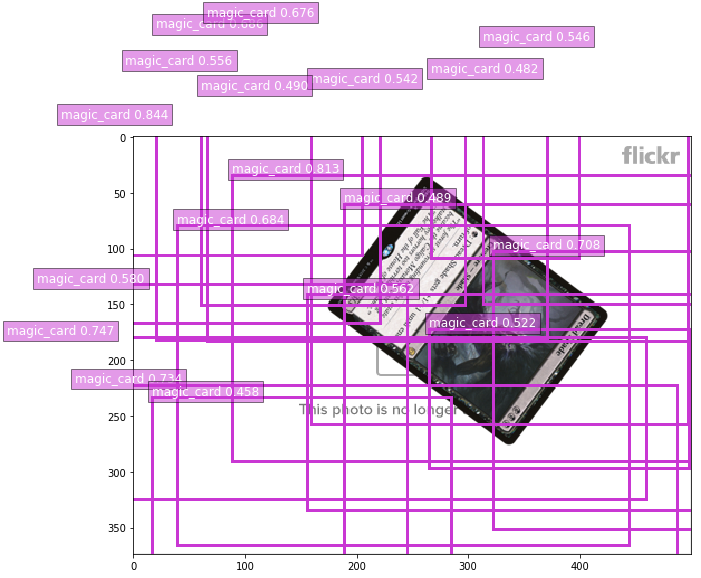

In [31]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

thresh = 0.45
#thresh = 0.55
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=thresh)

## Export the model to SageMaker

We're following the instructions from [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/mxnet_mnist_byom/mxnet_mnist.ipynb) starting with **Set up hosting for the model**

In [32]:
# TODO: THis? https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html

import os
import json
#os.mkdir('model')

savedir = 'data/model'

#net.save_checkpoint(savedir + '/model', 0000)
#with open ( savedir + '/model-shapes.json', "w") as shapes:
#    json.dump([{"shape": net.data_shapes[0][1], "name": "data"}], shapes)

net.export(savedir, epochs)

import tarfile
def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo

tar = tarfile.open("data/model.tar.gz", "w:gz")
tar.add(savedir, filter=flatten)
tar.close()


RuntimeError: Please first call block.hybridize() and then run forward with this block at least once before calling export.

In [ ]:
import time

query = input("Type the name of the set: ")

time.sleep(0.05)
sets = scrython.sets.Sets()

for i in range(sets.data_length()):
    if sets.set_name(i) == query:
        print("Set code:", sets.set_code(i).upper())
        break
    else:
        continue